# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache2")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 32)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2, make_plots
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

devices = ["cuda:0", "cuda:0", "cuda:1", "cuda:2", "cuda:3",]
# devices = ["cpu"] * 5
device = torch.device(devices[0] if torch.cuda.is_available() else "cpu")
device1 = torch.device(devices[1] if torch.cuda.is_available() else "cpu")
device2 = torch.device(devices[2] if torch.cuda.is_available() else "cpu")
device3 = torch.device(devices[3] if torch.cuda.is_available() else "cpu")
device4 = torch.device(devices[4] if torch.cuda.is_available() else "cpu")

set_device(device)
print(get_device())

scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
set_global("gradient_clipping", 10)
# Use mixup in SSL training, Use UDA maybe
# os.path.join(get_global("models_dir"),)


cuda:0


In [2]:
views = 0
sep = " [SEP] "
add_objects_and_caption = False
from collections import defaultdict
obcp = pd.read_csv("/home/ahemf/cache/data/objects_captions.csv").values
object_captions = defaultdict(dict)
for d in obcp:
    object_captions[d[0]]["objects"] = d[1]
    object_captions[d[0]]["caption"] = d[2]
    


In [ ]:

def get_tta_text(tta_id):
    dab_file="/home/ahemf/cache/data/hard_dab.csv"
    dab = pd.read_csv(dab_file).values
    dab_store = defaultdict(list)
    
    sentence_level = {"glove_twitter": 1.0,}
    sentence_level = TextAugment([0.0, 1.0], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    word_mask = {"word_masking": 1.0}
    word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    char_level = {"keyboard": 0.1, "char_substitute": 0.75, "char_insert": 0.2, "char_swap": 0.2, 
                  "char_delete": 0.1, "vowel_replace": 0.75}
    char_level = TextAugment([0.0, 1.0], char_level)
    
    vowel = {"vowel_replace": 0.75}
    vowel = TextAugment([0.0, 1.0], vowel)
    
    word_level = {"split": 0.2, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.0, 1.0], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, 
                 "punctuation_continue": 0.5}
    gibberish = TextAugment([0.0, 1.0], gibberish)
                                 
    for d in dab:
        dab_store[int(d[0])].append(d[1])
    for k, v in dab_store.items():
        dab_store[k] = list(sorted(v, key=len, reverse=True))
    
    def tta(text, **kwargs):
        identifier = kwargs.pop("identifier")
        ptext = text
        if tta_id == 0:
            return text
        if tta_id == 1:
            if identifier in dab_store:
                text = dab_store[identifier][0]
            else:
                text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
        if tta_id == 2:
            if identifier in dab_store and len(dab_store[identifier]) > 1:
                text = dab_store[identifier][1]
            else:
                text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
        if tta_id == 3:
            if identifier in dab_store and len(dab_store[identifier]) > 2:
                text = dab_store[identifier][2]
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 4:
            if identifier in dab_store and len(dab_store[identifier]) > 3:
                text = dab_store[identifier][3]
                text = char_level(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 5:
            if identifier in dab_store and len(dab_store[identifier]) > 4:
                text = dab_store[identifier][4]
                text = gibberish(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 6:
            if identifier in dab_store and len(dab_store[identifier]) > 5:
                text = dab_store[identifier][5]
                text = gibberish(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = gibberish(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 7:
            if identifier in dab_store and len(dab_store[identifier]) > 6:
                text = dab_store[identifier][6]
            else:
                text = sentence_level(text, **kwargs)
                text = word_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                text = char_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 8:
            text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 9:
            text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 10:
            text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 11:
            text = word_mask(text, **kwargs)
            if text == ptext:
                text = sentence_level(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 12:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id == 13:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id == 14:
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id >= 15:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = char_level(text, **kwargs)
            
        if add_objects_and_caption and views==0:
            caption = str(object_captions[identifier]["caption"])
            objects = str(object_captions[identifier]["objects"])
            if random.random() < 0.5:
                caption = word_mask(caption, **kwargs)
                objects = word_mask(objects, **kwargs)
            else:
                caption = sentence_level(caption, **kwargs)
                objects = sentence_level(objects, **kwargs)
            
            text = text + sep + caption + sep + objects
        
        return text
    return tta


In [3]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.25, "char_substitute": 0.5, "char_insert": 0.2, "char_swap": 0.2, 
                  "char_delete": 0.1, "vowel_replace": 1.0}
    char_level = TextAugment([0.1, 0.9], char_level)
    word_level = {"split": 0.2, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.9], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"glove_twitter": 0.75, "part_select": 0.1, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, 
                 "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    
    word_mask = {"word_masking": 1.0}
    word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    def process(text, **kwargs):
        identifier = kwargs["identifier"]
        rng = random.random()
        if rng < 0.1:
            return text
        if rng > 0.25 and rng <= 0.45:
            text = sentence_level(text, **kwargs)
        elif rng > 0.45:
            ptext = text
            text = translation(text, **kwargs)
            if ptext == text:
                text = sentence_level(text, **kwargs)

        if random.random() > 0.25:
            text = word_level(text, **kwargs)
            text = char_level(text, **kwargs)
            text = gibberish(text, **kwargs)
        else:
            text = word_mask(text, **kwargs)
        if add_objects_and_caption and views==0:
            caption = str(object_captions[identifier]["caption"])
            objects = str(object_captions[identifier]["objects"])
            if random.random() < 0.5:
                caption = word_mask(caption, **kwargs)
                objects = word_mask(objects, **kwargs)
            else:
                caption = sentence_level(caption, **kwargs)
                objects = sentence_level(objects, **kwargs)
                
            text = text + sep + caption + sep + objects
        return text
    return process
preprocess_text = get_preprocess_text()

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        ag_idx = imv + 1
        word_mask = {"word_masking": 1.0}
        word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
        def aug_sample(sample):

            text = preprocess_text(sample.original_text, identifier=sample.id)
            identifier=sample.id
            
            if add_objects_and_caption:
                caption = str(object_captions[identifier]["caption"])
                objects = str(object_captions[identifier]["objects"])
                caption = word_mask(caption, identifier=sample.id)
                objects = word_mask(objects, identifier=sample.id)
                text = text + sep + caption + sep + objects
                
            sample["text_view_%s" % ag_idx] = text
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    views_array = []
    for i in range(views):
        views_array.append(get_view(i))
    return views_array



In [4]:
data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)

intersection = set(data["dev_unseen"]["id"]).intersection(set(data["train"]["id"]))
len(intersection)

intersection = set(data["dev"]["id"]).intersection(set(data["train"]["id"]))
len(intersection)

intersection = set(data["dev_unseen"]["id"]).intersection(set(data["dev"]["id"]))
len(intersection)

0

100

400

In [5]:
data["train"].shape
data["dev"].shape
data["dev_unseen"].shape
data["test"].shape
data["test_unseen"].shape


(8600, 4)

(500, 4)

(540, 4)

(1000, 3)

(2000, 3)

In [6]:
data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
dev_unseen["label"] = -1
test_seen = data["test"]
test_unseen = data['test_unseen']
test_seen = test_seen[~test_seen["id"].isin(set(test_unseen["id"]))]
test_seen.shape

df = pd.concat((data["train"],
                dev_unseen,
                data["test"], data['test_unseen']))
df.shape


(1000, 4)

(12140, 4)

In [7]:

dataset = convert_dataframe_to_dataset(df, data["metadata"], True, additional_processors=get_views())


In [8]:
dataset[0]

Sample([('id', 42953),
        ('text', 'your character not [MASK] [MASK] color that matters'),
        ('label', 0),
        ('sample_weight', 1.0),
        ('image',
         <PIL.Image.Image image mode=RGB size=265x400 at 0x7F6F46564FD0>),
        ('mixup', False),
        ('original_image',
         <PIL.Image.Image image mode=RGB size=265x400 at 0x7F6F465ADF10>),
        ('original_text', 'its their character not their color that matters')])

In [9]:
dataset[1024]

Sample([('id', 7826),
        ('text',
         'Whenever you have to r * ly on yo*r enemy for a job that is m ss ed *p!'),
        ('label', 0),
        ('sample_weight', 1.0),
        ('image',
         <PIL.Image.Image image mode=RGB size=534x800 at 0x7F6F46570790>),
        ('mixup', False),
        ('original_image',
         <PIL.Image.Image image mode=RGB size=534x800 at 0x7F6F465AD690>),
        ('original_text',
         "any time you have to rely upon your enemy for a job you're in bad shape!")])

In [10]:
views


0

In [11]:
model_params = dict(
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.1,
    feature_dropout=0.01,
    word_masking_proba=0.15,
    whole_word_masking=True,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=160 if add_objects_and_caption else 96,
    n_tokens_out=160 if add_objects_and_caption else 96,
    loss="focal",
    bbox_swaps=1,
    bbox_copies=1,
    bbox_deletes=1,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.01,
    bbox_dropout=0.01,
    view_transforms=get_views(),
    view_loss_weight=0.1,
    devices=dict(lxmert=device1, vilbert=device4, 
                 visual_bert=device3, mmbt_region=device2),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)

del model.vilbert.model.classifier
del model.visual_bert.model.classifier
del model.mmbt_region.model.classifier




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Overriding option config to projects/hateful_memes/configs/mmbt/with_features.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.features
Overriding option evaluation.predict to true


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


In [12]:
# torch.save(model.lxmert.state_dict(), os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth"))
# model.lxmert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth")))

# torch.save(model.mmbt_region.state_dict(), os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth"))
# model.mmbt_region.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth")))


# torch.save(model.visual_bert.state_dict(), os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth"))
# model.visual_bert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth")))

# torch.save(model.vilbert.state_dict(), os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth"))
# model.vilbert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth")))




# Unimodal MLM

In [13]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None, mlm_loss_weight=1.0,)
# mlm_model = mlm_model.to(get_device())
# mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
# mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
# mlm_model = mlm_model.to(get_device())


In [14]:
# torch.save(mlm_model.state_dict(), "mlm-model-v2-view-1.pth")



In [ ]:

clean_memory()
lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": True,},
        "visual_bert": {"finetune": True,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlm": {"finetune": True},
}
epochs = 5
batch_size = 8
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=2e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
# optimizer_params = dict(lr=2e-5, momentum=0.9, weight_decay=1e-3, nesterov=True)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                        model_call_back=None, accumulation_steps=8, 
                                        plot=True,
                                        sampling_policy=None, class_weights=None)




Autocast =  True Epochs =  5 Divisor = 1 Examples = 12140 Batch Size =  8
Training Samples =  12140 Weighted Sampling =  False Num Batches =  1518 Accumulation steps =  8
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


FeatureExtractor : Loaded Model...
Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...


In [14]:
clean_memory()


In [35]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

train_stats = get_global("train_stats")
train_stats


defaultdict(float,
            {'called': 278840.0,
             'hit': 278827.0,
             'read_time': 0.0024748173727676764,
             'key_error': 13.0,
             'read-return-none': 13.0,
             'compute': 13.0,
             'writes': 13.0,
             'write_time': 0.01114091701780045})

defaultdict(float,
            {'called': 278824.0,
             'hit': 278811.0,
             'read_time': 0.001973142555206201,
             'key_error': 13.0,
             'read-return-none': 13.0,
             'compute': 13.0,
             'writes': 13.0,
             'write_time': 0.007062704319067188})

defaultdict(float,
            {'batch_time': 0.02385452107341537,
             'model_time': 16.428041089757897})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


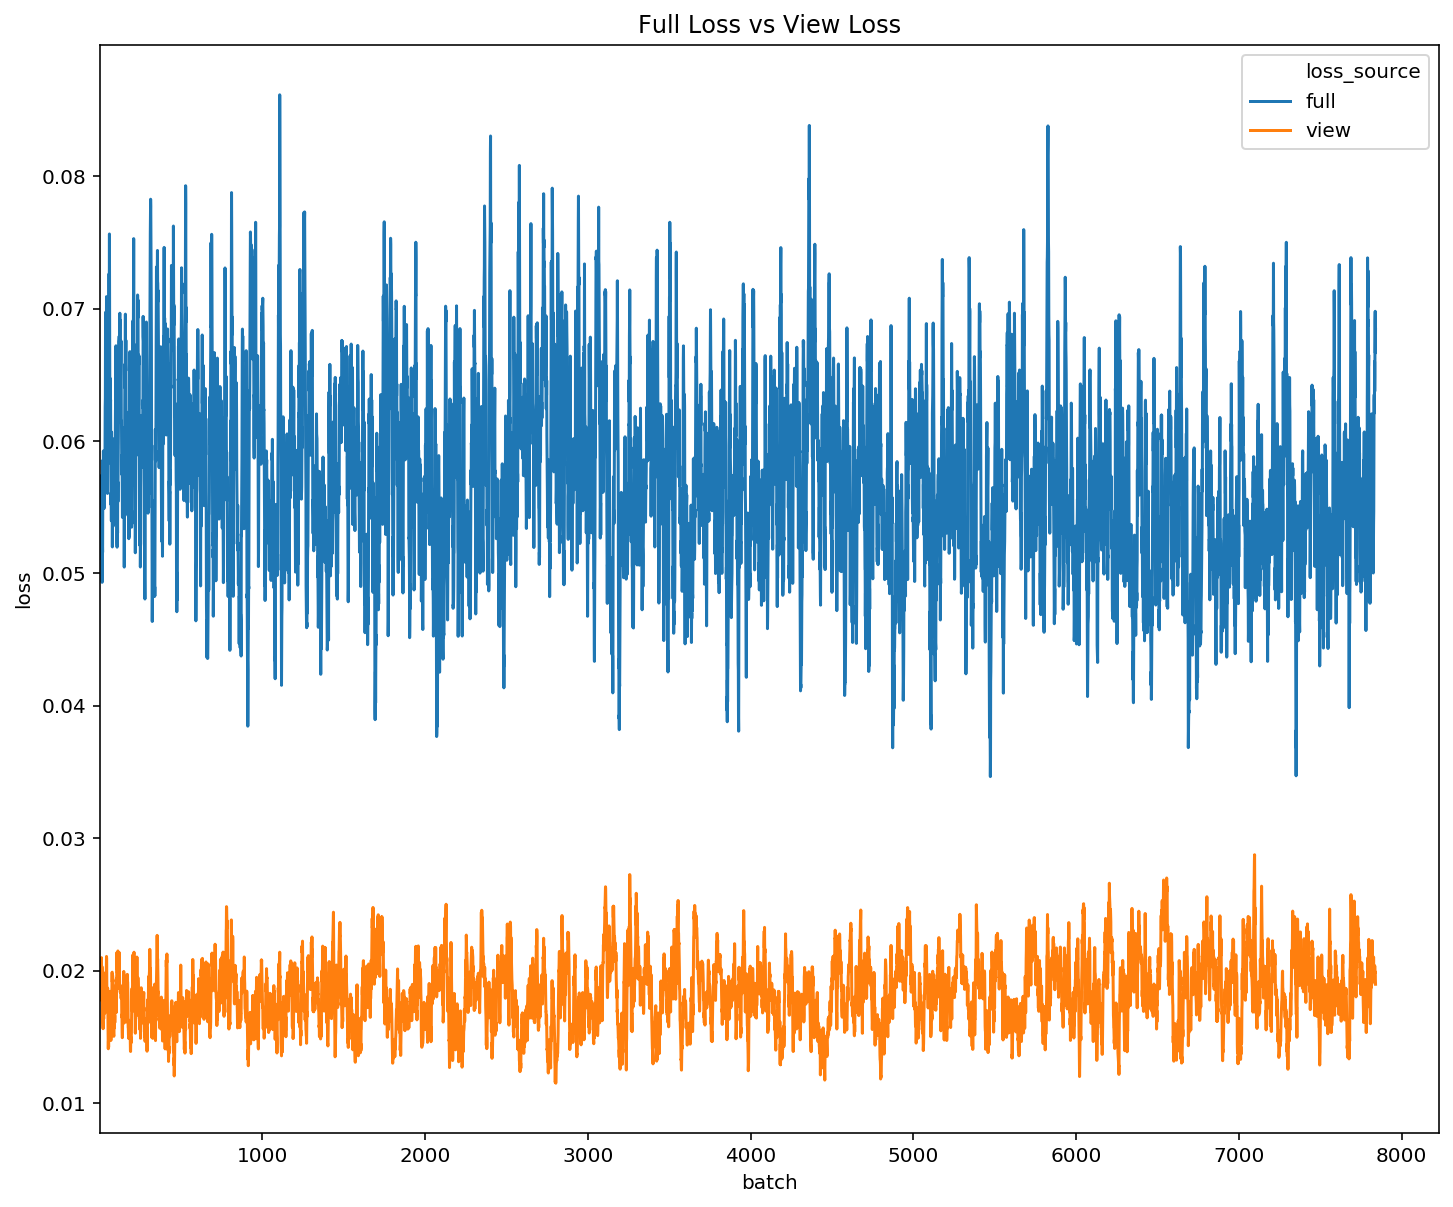

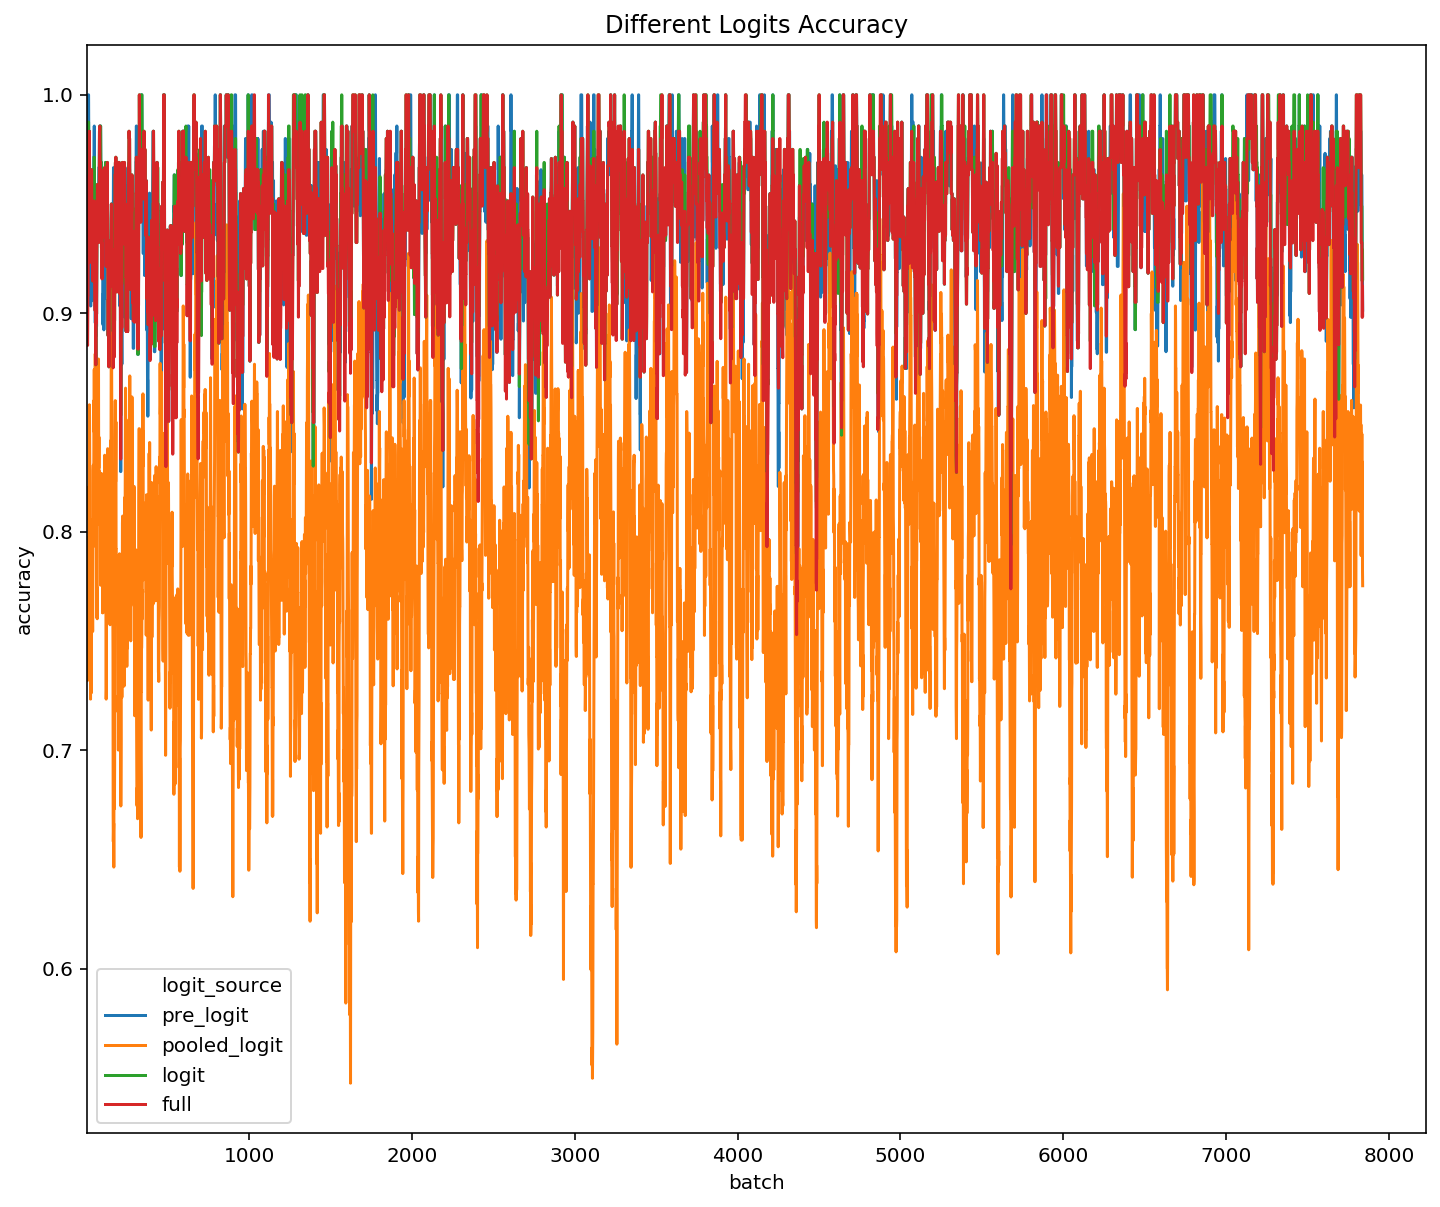

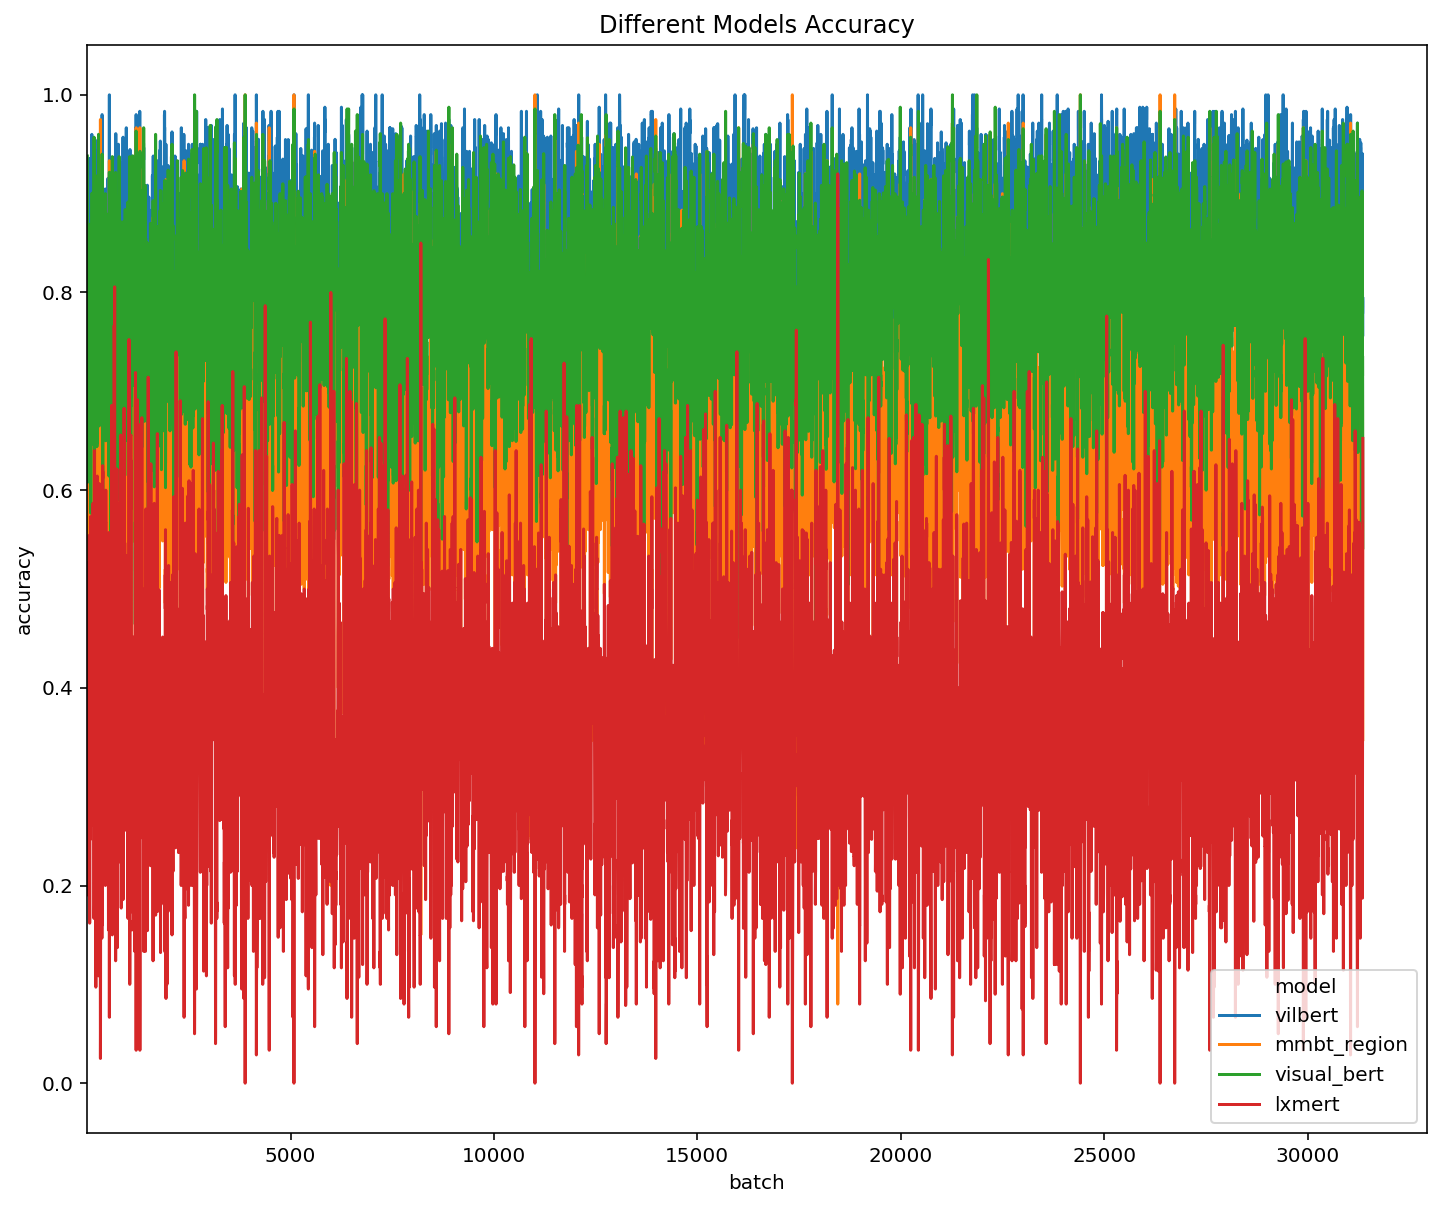

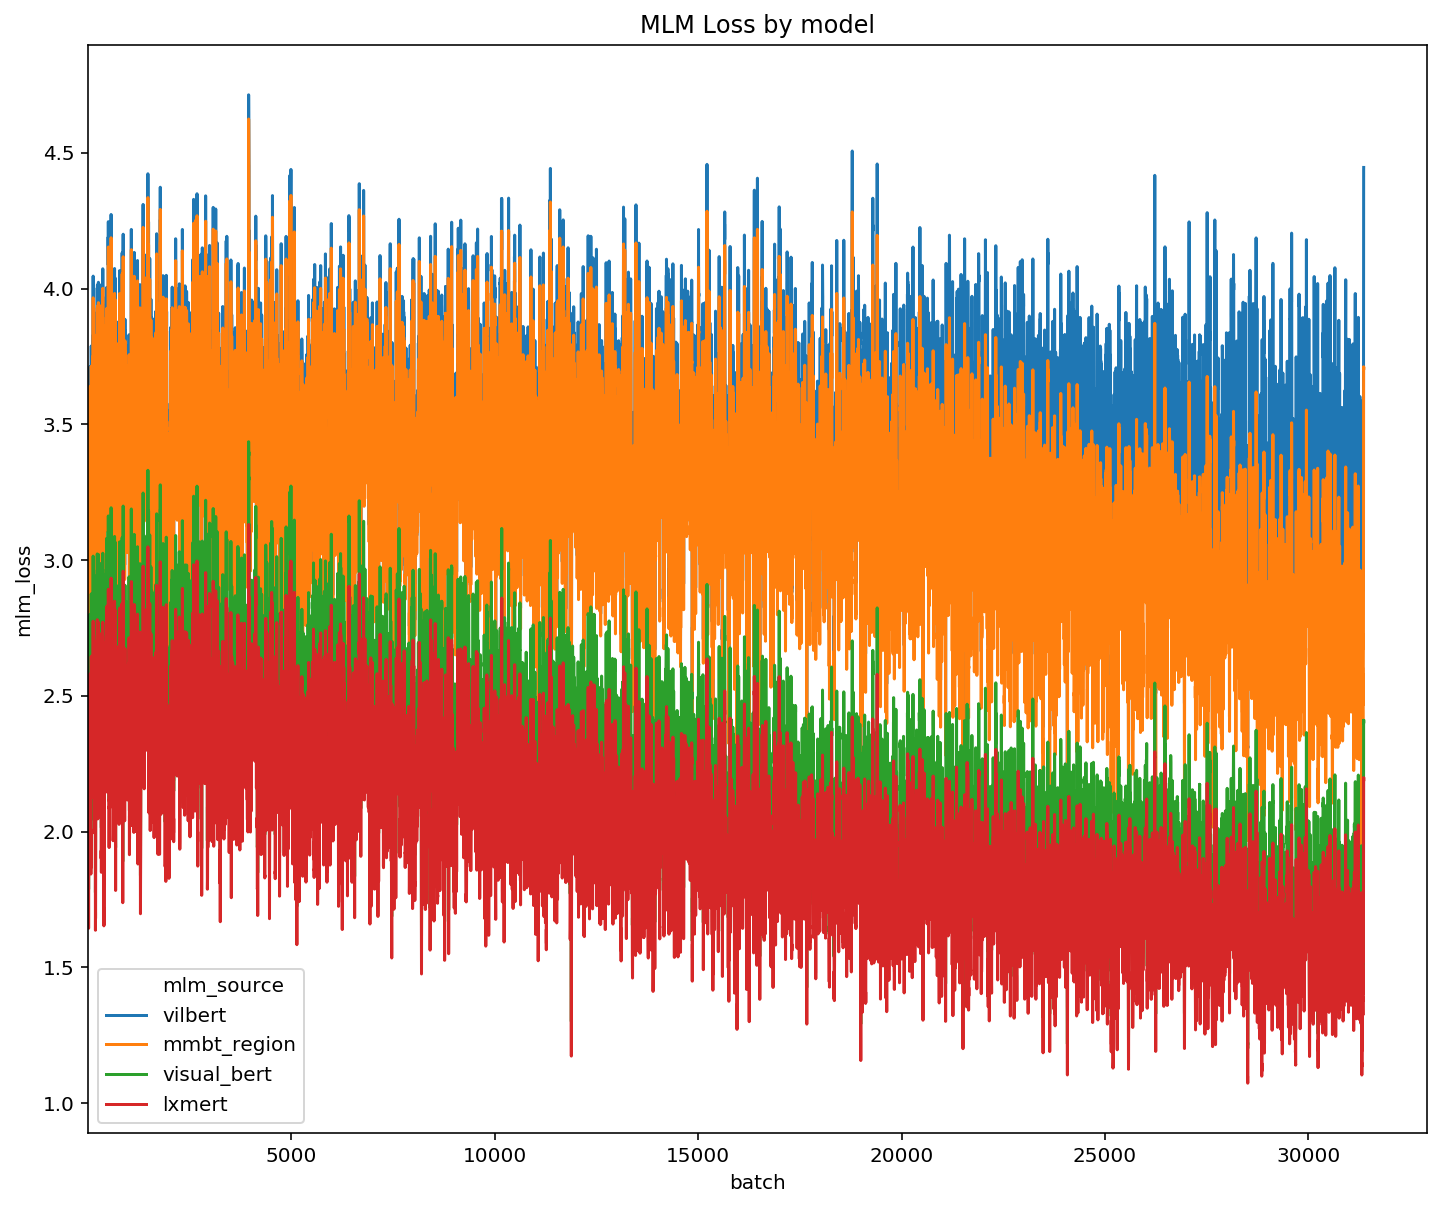

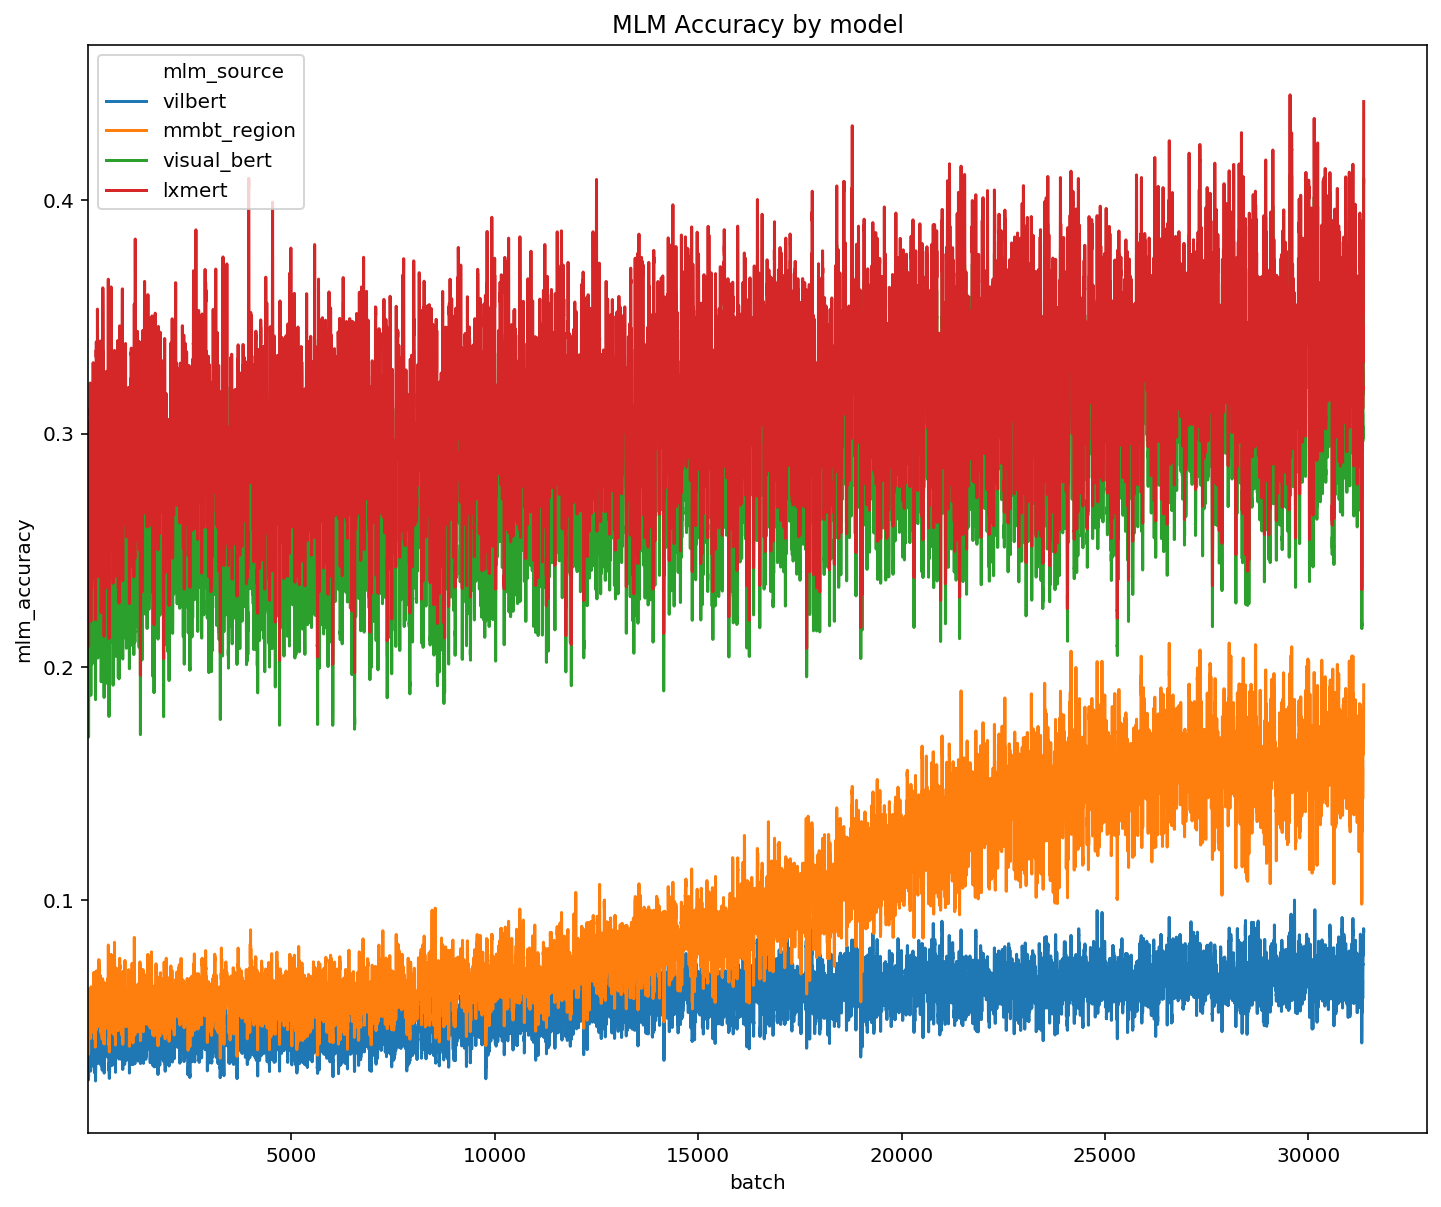

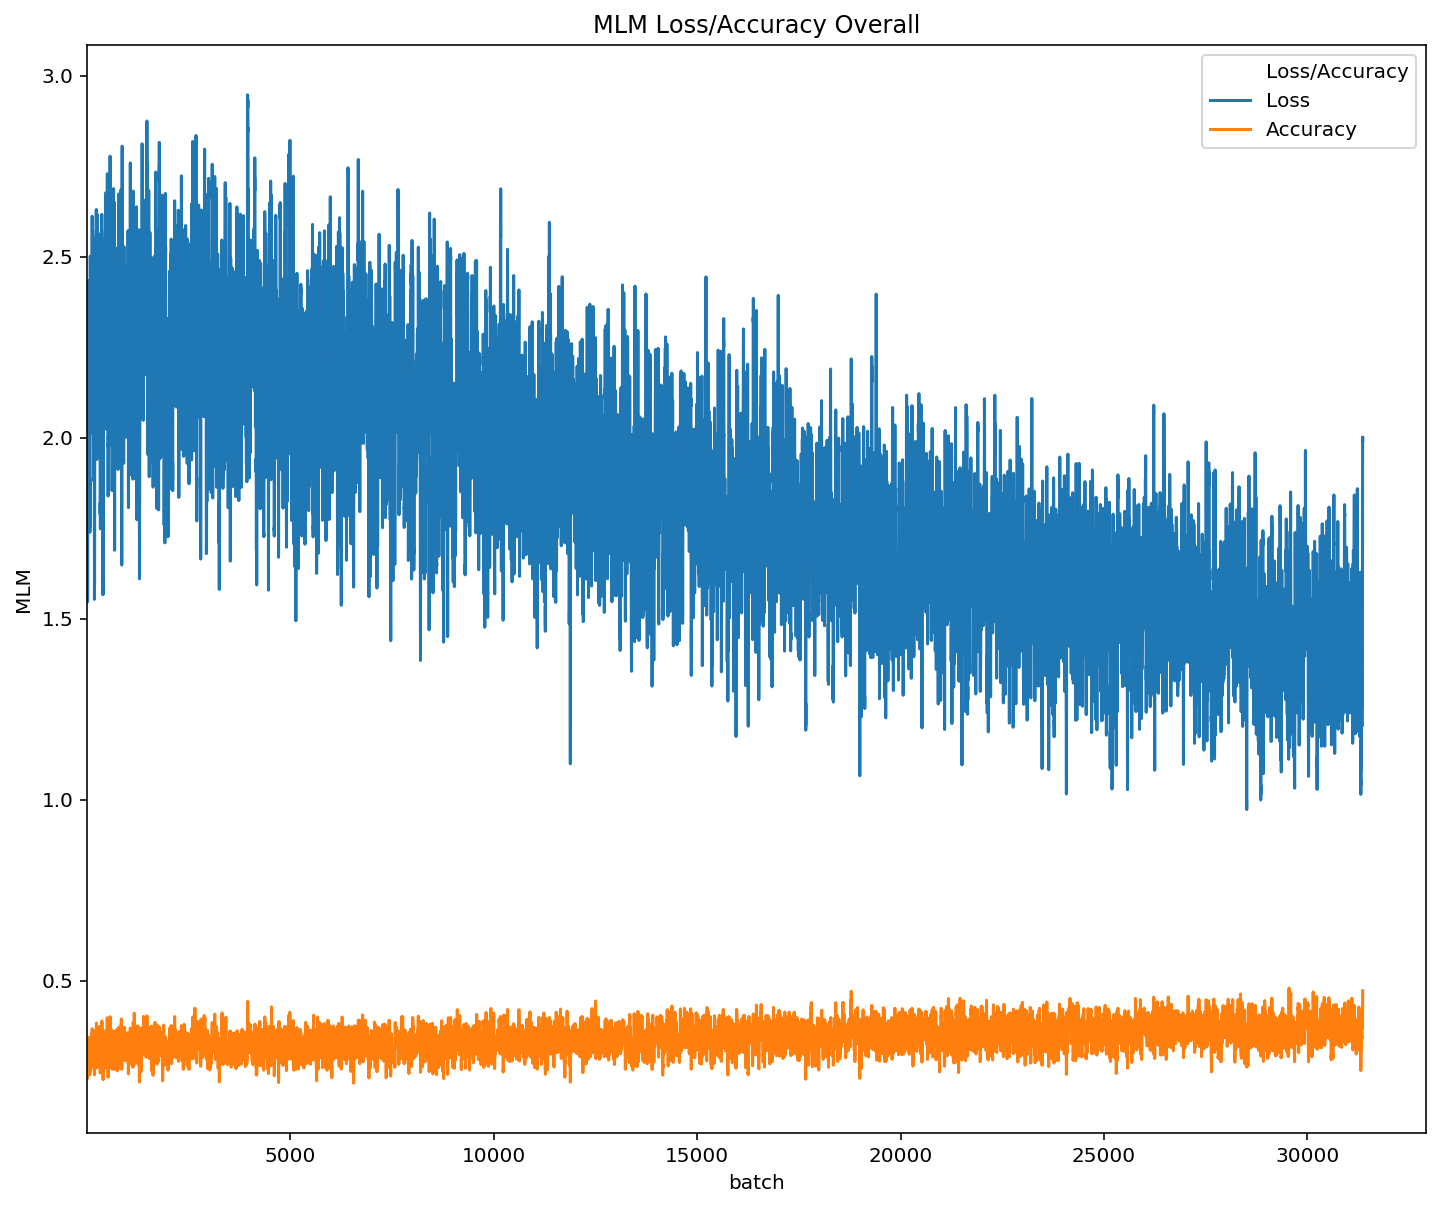

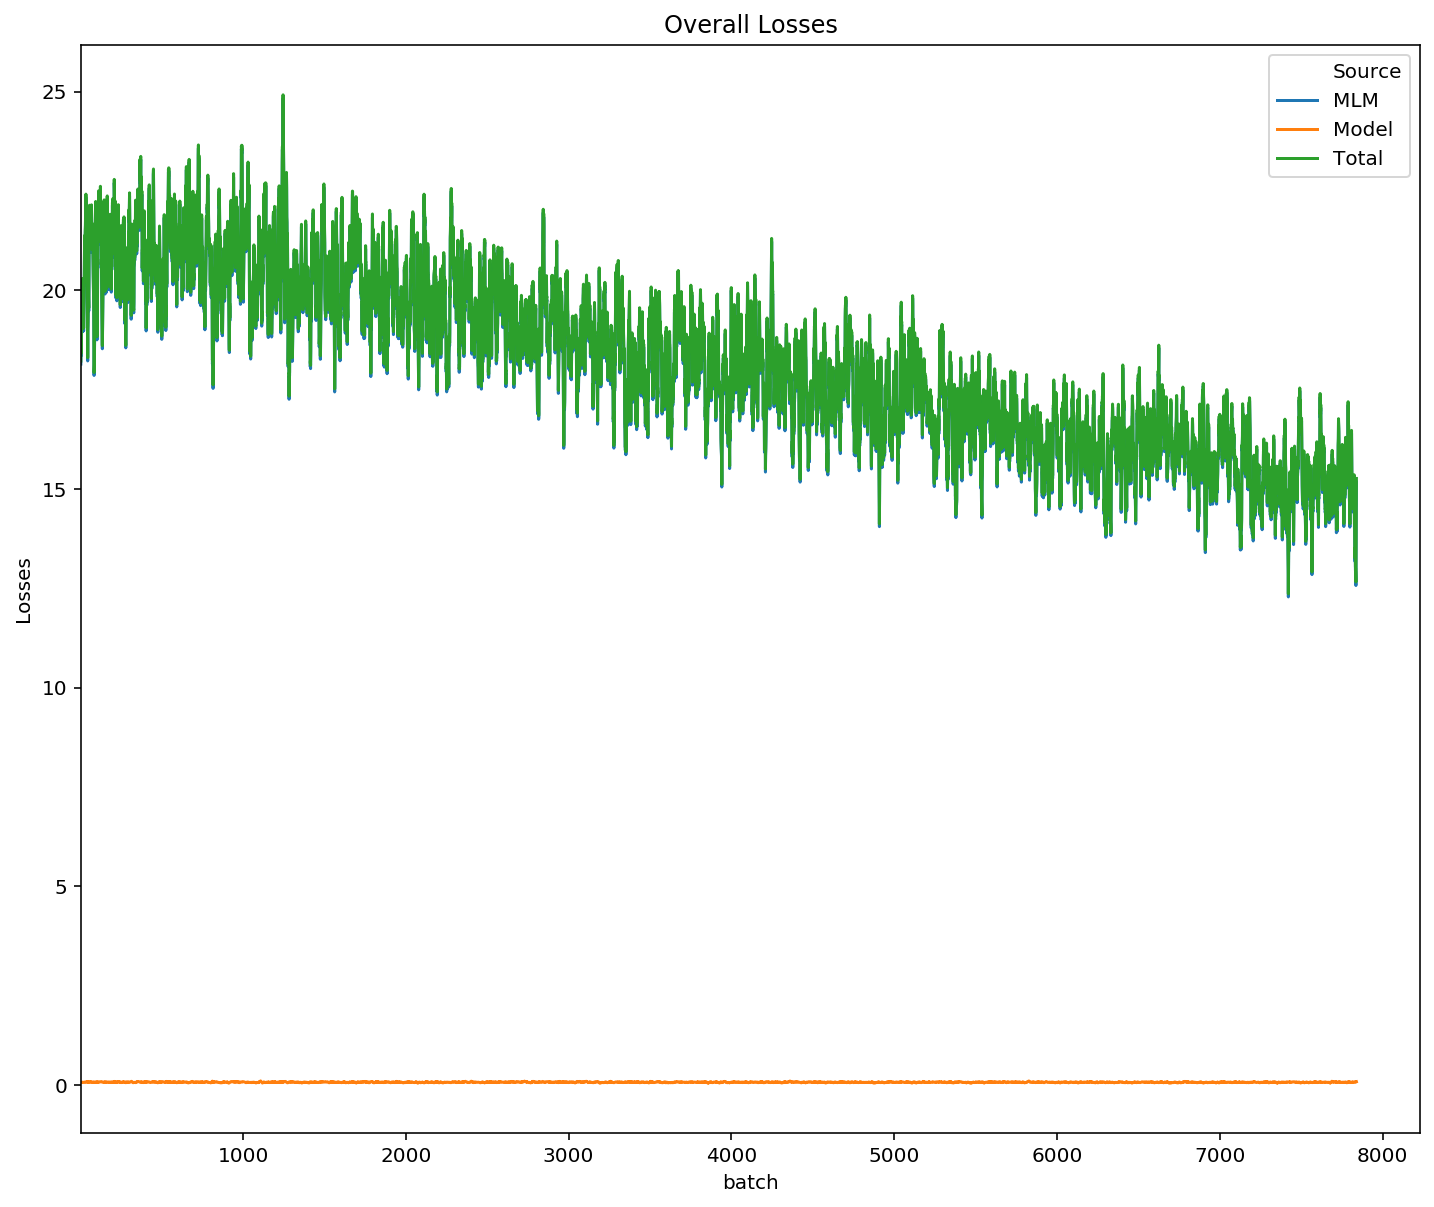

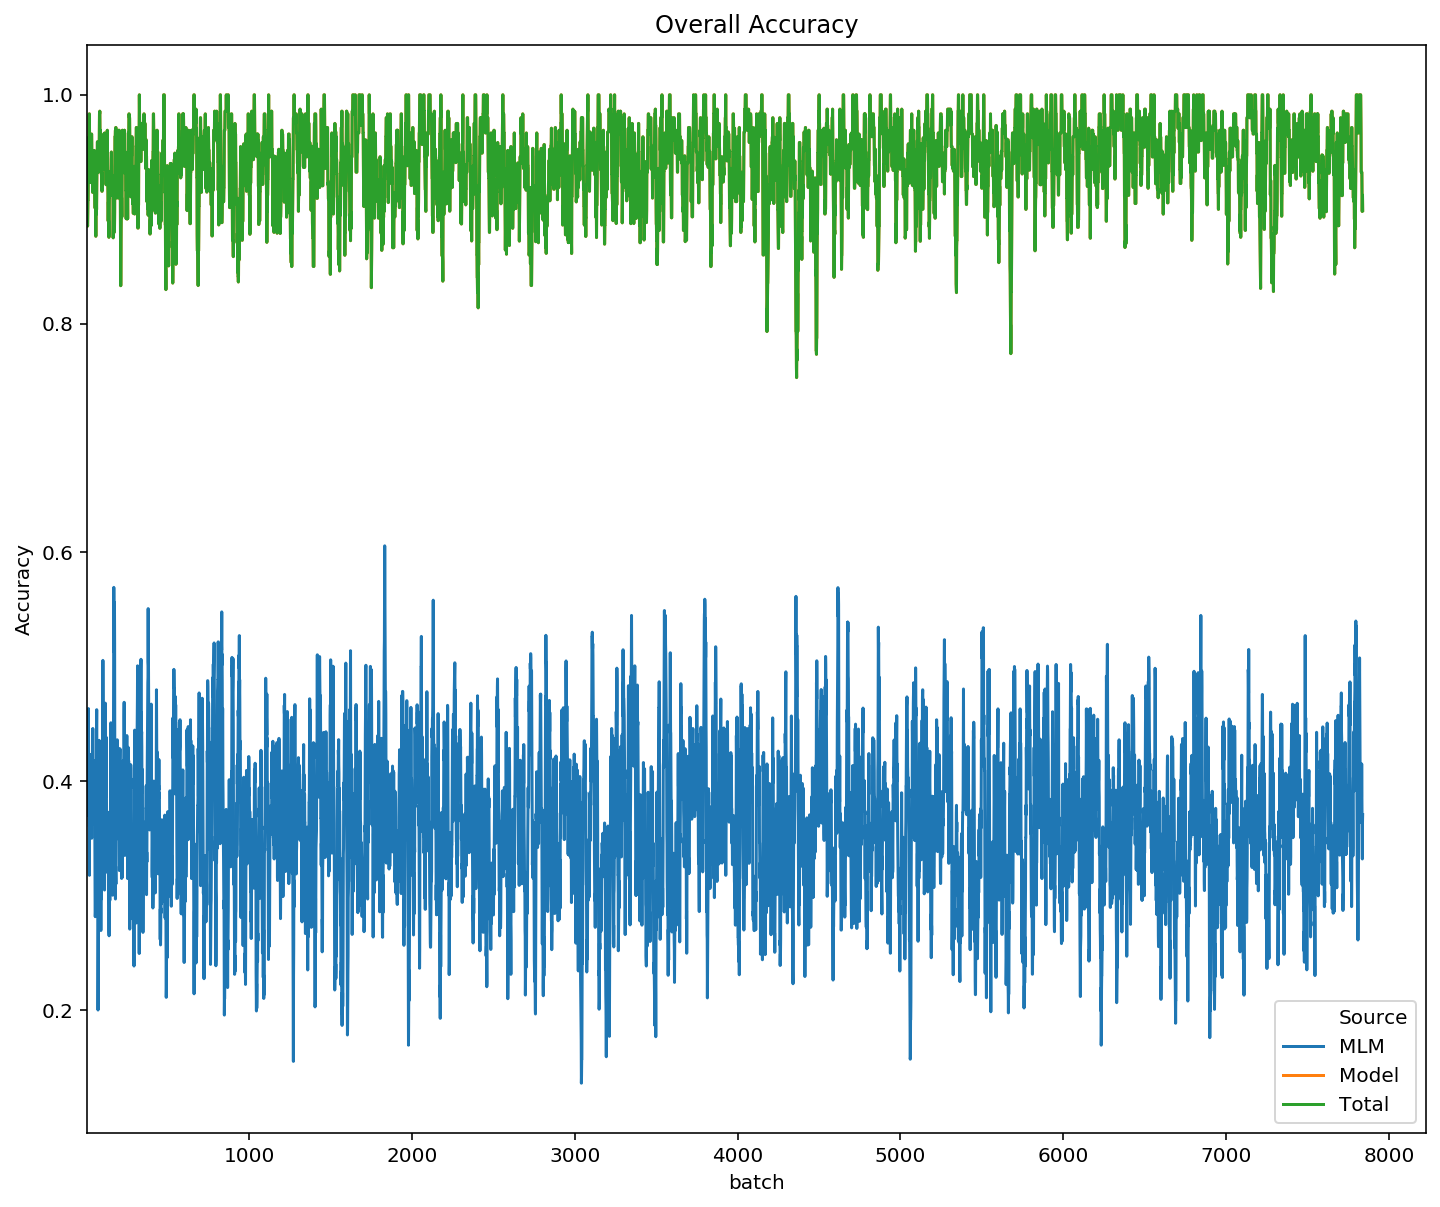

In [15]:
make_plots(model, mlm_model, logy=False, exclude_from_start=5, smoothing=10)

# Single Eval

## Validate

In [16]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)
# scores =  {'map': '0.7743', 'acc': '0.6320', 'auc': '0.7916'}
# scores =  {'map': '0.9436', 'acc': '0.8260', 'auc': '0.9410'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.410 0.548     0   1
1      0.440 0.587     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.440,"[0.5603821277618408, 0.4396178424358368]",0,0,0.452,"[0.5476847290992737, 0.45231524109840393]",0,0,0.525,"[0.47495827078819275, 0.5250416994094849]",1,1
1,0.510,"[0.4902864694595337, 0.5097135305404663]",1,1,0.540,"[0.46036407351493835, 0.5396358966827393]",1,1,0.563,"[0.4369765520095825, 0.5630234479904175]",1,1
2,0.414,"[0.5861123204231262, 0.4138876497745514]",0,0,0.582,"[0.4184724688529968, 0.5815275311470032]",1,1,0.528,"[0.47181013226509094, 0.5281898975372314]",1,1
3,0.419,"[0.5812404155731201, 0.41875964403152466]",0,0,0.467,"[0.5326627492904663, 0.4673372805118561]",0,1,0.542,"[0.4575626254081726, 0.5424373745918274]",1,1
4,0.532,"[0.46750617027282715, 0.5324938297271729]",1,1,0.587,"[0.4130602777004242, 0.5869396924972534]",1,1,0.462,"[0.5379316806793213, 0.4620683193206787]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,245,8,253.000,96.000
1,23,224,247.000,90.000
Predicted Counts,268,232,500.000,nan
Precision %,91,96,nan,nan


scores =  {'map': '0.9819', 'acc': '0.9380', 'auc': '0.9838'}


([0.9818689548125961, 0.938, 0.983757661103199],
 (array([0.9141791 , 0.96551724]),
  array([0.96837945, 0.90688259]),
  array([0.94049904, 0.93528184]),
  array([253, 247])))

In [17]:
data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)


In [18]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)
# scores =  {'map': '0.8509', 'acc': '0.8426', 'auc': '0.9048'}
# scores =  {'map': '0.6208', 'acc': '0.6796', 'auc': '0.7552'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.412 0.558     0   1
1      0.444 0.587     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.475,"[0.524677038192749, 0.475322961807251]",0,0,0.429,"[0.5714691877365112, 0.42853084206581116]",0,0,0.423,"[0.5771587491035461, 0.42284128069877625]",0,0
1,0.475,"[0.5252840518951416, 0.4747158885002136]",0,1,0.539,"[0.4607687294483185, 0.5392312407493591]",1,1,0.420,"[0.580339252948761, 0.4196607172489166]",0,0
2,0.435,"[0.5654809474945068, 0.43451908230781555]",0,0,0.421,"[0.5786754488945007, 0.42132458090782166]",0,0,0.438,"[0.5618436336517334, 0.4381563663482666]",0,0
3,0.542,"[0.45847901701927185, 0.5415210127830505]",1,0,0.510,"[0.4901140034198761, 0.5098860263824463]",1,1,0.531,"[0.46853235363960266, 0.5314676761627197]",1,1
4,0.534,"[0.4657931327819824, 0.5342068672180176]",1,1,0.481,"[0.5190778374671936, 0.4809221923351288]",0,0,0.447,"[0.5529695153236389, 0.4470304846763611]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,324,16,340.000,95.000
1,24,176,200.000,88.000
Predicted Counts,348,192,540.000,nan
Precision %,93,91,nan,nan


scores =  {'map': '0.9375', 'acc': '0.9259', 'auc': '0.9703'}


([0.9374759030370388, 0.9259259259259259, 0.9703235294117647],
 (array([0.93103448, 0.91666667]),
  array([0.95294118, 0.88      ]),
  array([0.94186047, 0.89795918]),
  array([340, 200])))

### Higher Prediction Iters

In [24]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True, prediction_iters=10)



Proba       Preds    
         min   max   min max
Labels                      
0      0.425 0.546     0   1
1      0.427 0.552     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.436,"[0.56362384557724, 0.43637609481811523]",0,1,0.484,"[0.5159763097763062, 0.48402372002601624]",0,1,0.474,"[0.526252269744873, 0.47374778985977173]",0,0
1,0.432,"[0.5680425763130188, 0.4319573938846588]",0,0,0.431,"[0.5692330598831177, 0.43076691031455994]",0,1,0.455,"[0.545210063457489, 0.454789936542511]",0,0
2,0.432,"[0.5681908130645752, 0.4318091869354248]",0,1,0.498,"[0.5018841028213501, 0.4981158375740051]",0,0,0.503,"[0.4972473084926605, 0.5027526617050171]",1,1
3,0.432,"[0.5681312084197998, 0.4318687915802002]",0,0,0.488,"[0.5123557448387146, 0.4876441955566406]",0,0,0.435,"[0.5653418898582458, 0.43465811014175415]",0,0
4,0.455,"[0.5446900129318237, 0.45531001687049866]",0,0,0.433,"[0.5670970678329468, 0.4329029619693756]",0,0,0.431,"[0.5689241886138916, 0.4310758113861084]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,314,26,340.000,92.000
1,144,56,200.000,28.000
Predicted Counts,458,82,540.000,nan
Precision %,68,68,nan,nan


scores =  {'map': '0.6243', 'acc': '0.6852', 'auc': '0.7556'}


([0.6242666160333027, 0.6851851851851852, 0.7556176470588235],
 (array([0.68558952, 0.68292683]),
  array([0.92352941, 0.28      ]),
  array([0.78696742, 0.39716312]),
  array([340, 200])))

## Predict

In [23]:
clean_memory()
batch_size = 16
preds = predict(mlm_model, data, batch_size, competition_phase=1, prediction_iters=10)


In [24]:
preds.to_csv("submission_phase_1.csv", index=False)

In [25]:
preds["label"].value_counts()

0    774
1    226
Name: label, dtype: int64

In [26]:
clean_memory()
batch_size = 16
preds = predict(mlm_model, data, batch_size, competition_phase=2, prediction_iters=20)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
preds.to_csv("submission_phase_2.csv", index=False)

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
